Устанавливаем и импортируем необходимые библиотеки, подключаем источник данных, проверяем данные 


In [ ]:
! pip install tensorflow==2.0.0
# !pip install tensorflow-gpu==2.0.0
!pip install -U git+https://github.com/qubvel/efficientnet
!pip install livelossplot
!pip install 'h5py==2.10.0' --force-reinstall

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot.tf_keras import PlotLossesCallback
# from keras_tqdm import TQDMCallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path
import os

print(tf. __version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [2]:
drive.mount('/content/drive/')

df = pd.read_csv('/content/drive/MyDrive/data_for_emotion_recognition/train.csv')

data_folder = '/content/drive/MyDrive/data_for_emotion_recognition/'

df.image_path = df.image_path.replace('[./]/','/', regex=True)
df['full_image_path']  = data_folder + df.image_path 

print(df.shape)
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(50046, 4)


,Unnamed: 0,image_path,emotion,full_image_path
0,0,/train/anger/0.jpg,anger,/content/drive/MyDrive/data_for_emotion_recogn...
1,1,/train/anger/1.jpg,anger,/content/drive/MyDrive/data_for_emotion_recogn...
2,2,/train/anger/10.jpg,anger,/content/drive/MyDrive/data_for_emotion_recogn...
3,3,/train/anger/100.jpg,anger,/content/drive/MyDrive/data_for_emotion_recogn...
4,4,/train/anger/1000.jpg,anger,/content/drive/MyDrive/data_for_emotion_recogn...


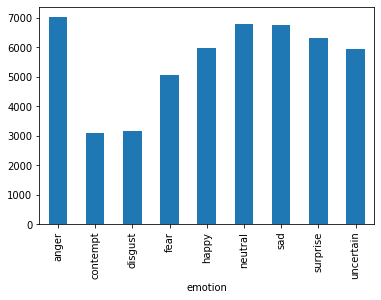

In [ ]:
df.groupby('emotion')['image_path'].count().plot.bar()

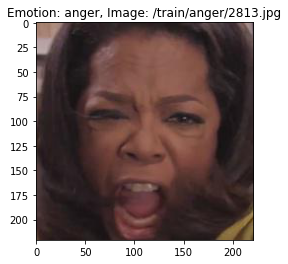

In [ ]:
def show_face(image, emotion, image_path):
    plt.imshow(image)
    plt.title(f"Emotion: {emotion}, Image: {image_path}")

row = df.iloc[np.random.randint(len(df))]
img = plt.imread(row['full_image_path'])
show_face(img, row['emotion'], row['image_path'])

In [ ]:
df['is_exist'] = df.full_image_path.map(lambda x: True if os.path.exists(x) else False)
df['is_exist'].value_counts()

True    50046
Name: is_exist, dtype: int64

Разделяем тренировочные данные на тренировочную и валидационную выборки, прдобрабатываем входные данные для дальнейшего обучения нейронной сети

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
BATCH_SIZE = 32
IMAGE_SIZE = 224

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
def image_preprocess(image,image_size=224):
  x = center_crop_and_resize(image, image_size=image_size)
  x = preprocess_input(x)
  x = np.expand_dims(x, 0)
  return x

fold='/content/drive/MyDrive/data_for_emotion_recognition'

image_gen = ImageDataGenerator(preprocessing_function=image_preprocess,horizontal_flip=True,brightness_range=[0.8,1],zoom_range=[0.85,1.15])
image_gen_val = ImageDataGenerator(preprocessing_function=image_preprocess)

train_generator = image_gen.flow_from_dataframe(dataframe = df_train, x_col='full_image_path', y_col='emotion', class_mode = "sparse",
                                                directory=str(fold),shuffle=True, batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE)) 
val_generator = image_gen_val.flow_from_dataframe(dataframe = df_test, x_col='full_image_path', y_col='emotion', class_mode = "sparse",
                                              directory=str(fold), shuffle=False, batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


In [ ]:
df_pred = pd.read_csv('/content/drive/MyDrive/data_for_emotion_recognition/sample_submission.csv')
fold_pred = '/content/drive/MyDrive/data_for_emotion_recognition/test_kaggle'
df_pred.head()

,image_path,emotion
0,0.jpg,neutral
1,1.jpg,neutral
2,2.jpg,neutral
3,3.jpg,neutral
4,4.jpg,neutral


In [ ]:
test_generator = image_gen_val.flow_from_dataframe(dataframe = df_pred, x_col='image_path', y_col=None,
                                              directory=str(fold_pred), shuffle=False, class_mode=None,
                                               batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 5000 validated image filenames.


In [ ]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1., 2., 3., 4., 5., 6., 7., 8.], "Неправильные метки классов"
print("Simple tests passed")

Simple tests passed


In [ ]:
emotion_mapping = dict(list(enumerate(('anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise', 'uncertain'))))

def show_faces(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    all_labels = {'name': [predicted_labels, labels]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for  name, (predicted, real) in all_labels.items():
            if predicted is None:
              real_labels = int(real[i])
              real_str += f"{emotion_mapping[real_labels]}, "
              pred_str = 'None'
            else:
              real_labels = int(real[i])
              predicted_labels =  np.argmax(predicted[i])
              real_str += f"{emotion_mapping[real_labels]}, "
              pred_str += f"{emotion_mapping[pred_str]}, "
              if real_labels != predicted_labels:
                  correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

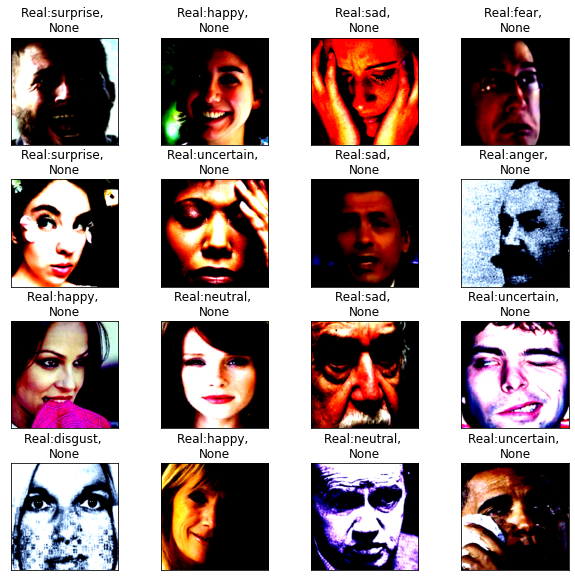

In [ ]:
sample_training_images, sample_labels = next(train_generator) 
show_faces(sample_training_images, sample_labels)

Создвем коллбеки для сохранения модели, добавляем так же early stopping во избежания переобучения и reducelronplateau для понижения скорости обучения при неизменяемом параметре лосс на 2-ух эпохах

In [6]:
path = Path("/content/drive/My Drive/Skillbox/model_emotional")
path.mkdir(exist_ok=True, parents=True) 
assert path.exists()
cpt_filename = "best_checkpoint_sep.h5"  
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
callb = [checkpoint,early,reduce_lr]

Инициализируем модель с весами

In [ ]:
import efficientnet.tfkeras as efc
base_model = efc.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.summary()

In [ ]:
base_model.trainable = True
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 11529     
Total params: 4,066,213
Trainable params: 1,510,249
Non-trainable params: 2,555,964
_________________________________________________________________


In [7]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/Skillbox/model_emotional/best_checkpoint_sep.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 11529     
Total params: 4,066,213
Trainable params: 1,510,249
Non-trainable params: 2,555,964
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=loss, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    epochs=100,
    steps_per_epoch=80,
    validation_steps=20,
    validation_data=val_generator
    ,callbacks=callb)

Epoch 1/100
79/80 [============================>.] - ETA: 11s - loss: 1.9114 - sparse_categorical_accuracy: 0.3552
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.36250, saving model to /content/drive/My Drive/Skillbox/model_emotional/best_checkpoint_sep.h5
80/80 [==============================] - 1047s 13s/step - loss: 1.9086 - sparse_categorical_accuracy: 0.3562 - val_loss: 1.7373 - val_sparse_categorical_accuracy: 0.3625
Epoch 2/100
79/80 [============================>.] - ETA: 11s - loss: 1.8569 - sparse_categorical_accuracy: 0.3568
Epoch 00002: val_sparse_categorical_accuracy improved from 0.36250 to 0.36719, saving model to /content/drive/My Drive/Skillbox/model_emotional/best_checkpoint_sep.h5
80/80 [==============================] - 1003s 13s/step - loss: 1.8584 - sparse_categorical_accuracy: 0.3555 - val_loss: 1.7487 - val_sparse_categorical_accuracy: 0.3672
Epoch 3/100
79/80 [============================>.] - ETA: 11s - loss: 1.8423 - sparse_categorical_a

In [ ]:
emotion_mapping = dict(list(enumerate(('anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise', 'uncertain'))))

pred = model.predict_generator(test_generator)

In [ ]:
predict=[]
for i in pred:
  pr = emotion_mapping[np.argmax(i)]
  predict.append(pr)
predict

In [ ]:
df_pred['emotion'] = predict 
df_pred.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,sad
3,3.jpg,disgust
4,4.jpg,neutral


In [ ]:
df_pred.to_csv('/content/drive/MyDrive/data_for_emotion_recognition/first_submission.csv', index=False)

In [8]:
model.save('saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/assets


Применяем библиотеку tensortrt для ускорения инференса нейронной сети

In [9]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [10]:
converter = trt.TrtGraphConverterV2(input_saved_model_dir="saved_model")
converter.convert()
converter.save('model_trt')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0
INFO:tensorflow:Assets written to: model_trt/assets


In [11]:
converter.save('/content/drive/MyDrive/data_for_emotion_recognition/model_trt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_for_emotion_recognition/model_trt/assets


In [21]:
%%timeit -n 10 -r 10
results = model(sample_training_images[:1])

221 ms ± 40.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [22]:
model_trt = tf.keras.models.load_model('model_trt')

In [23]:
%%timeit -n 10 -r 10
results = model_trt(sample_training_images[:1])

79.5 ms ± 18.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


Инференс модели до использования бибилиотеки tensort 221 ms, после 79,5 ms
ускорение инференса модели более чем в два раза